# Import modules

In [102]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import add_dummy_feature, OneHotEncoder, MinMaxScaler
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
%matplotlib inline

# Import cleaned dataset

In [3]:
df = pd.read_csv('final_df.csv', index_col=0).set_index('company_name').drop('as_of_date', axis=1)
df.head()

,followers_count,employees_on_platform,industry,checkins,were_here_count,likes,talking_about_count,stock_symbol
company_name,,,,,,,,
1800petmeds,1771,121,Retail,41,30,159898,16831,1
1st source bank,3523,921,Banking,191,0,5316,1048,1
21 club,610,167,Restaurants,9831,9831,6994,2279,1
3m,852348,58944,Mechanical or Industrial Engineering,3416,0,4497193,39516,1
aar corp.,17350,3712,Airlines/Aviation,174,174,1742,346,0


# Visualize data

In [4]:
corr_matrix = df.corr()

In [5]:
np.log(corr_matrix)

,followers_count,employees_on_platform,checkins,were_here_count,likes,talking_about_count,stock_symbol
followers_count,0.000000,-0.340378,-2.616230,-2.998245,-1.259699,-1.745171,-2.964269
employees_on_platform,-0.340378,0.000000,-4.078663,-1.633386,-1.580933,-2.033865,-2.975032
checkins,-2.616230,-4.078663,0.000000,-2.905301,-3.117462,-2.707913,-3.342756
were_here_count,-2.998245,-1.633386,-2.905301,0.000000,-1.459390,-2.034132,-2.923666
likes,-1.259699,-1.580933,-3.117462,-1.459390,0.000000,-0.715147,-2.540406
talking_about_count,-1.745171,-2.033865,-2.707913,-2.034132,-0.715147,0.000000,-2.798872
stock_symbol,-2.964269,-2.975032,-3.342756,-2.923666,-2.540406,-2.798872,0.000000


In [6]:
corr_matrix['stock_symbol'].sort_values()

checkins                 0.035339
employees_on_platform    0.051046
followers_count          0.051598
were_here_count          0.053736
talking_about_count      0.060879
likes                    0.078834
stock_symbol             1.000000
Name: stock_symbol, dtype: float64

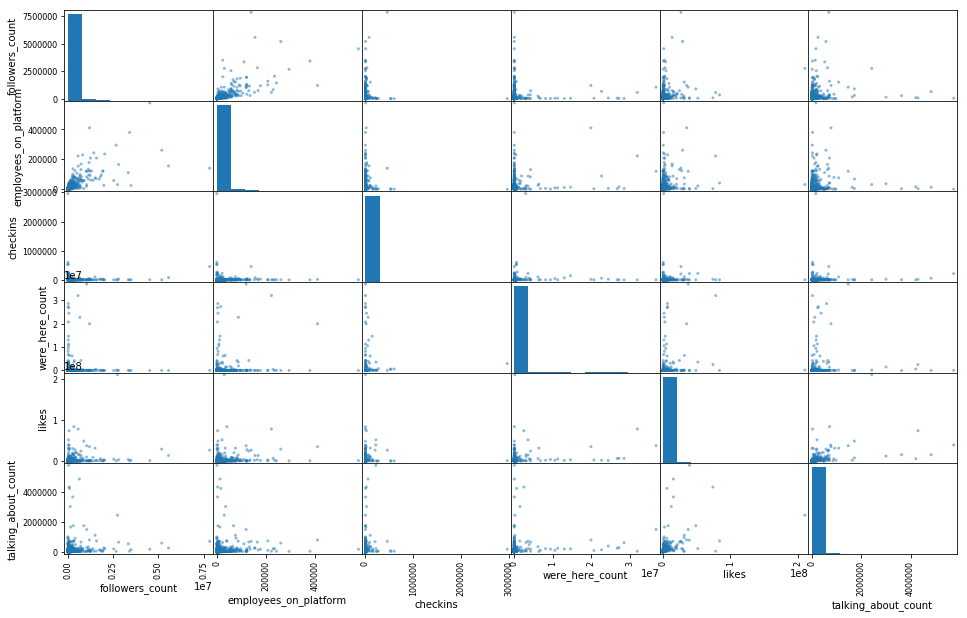

In [89]:
axarr = scatter_matrix(df.drop('stock_symbol', axis=1), figsize=(16,10))

# Tansformation pipline

In [63]:
df_dummy = pd.concat([df, pd.get_dummies(df.industry, prefix='industry_')], axis=1).drop('industry',axis=1)

In [64]:
X = df_dummy.drop('stock_symbol', axis=1)
y = df_dummy.stock_symbol

In [65]:
mm = MinMaxScaler()
X = pd.DataFrame(mm.fit_transform(X), columns=X.columns)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=17)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Training

## Decision Tree Classifier

In [40]:
dtc = DecisionTreeClassifier()
param_grid = [
    {'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'max_leaf_nodes': [2, 3, 4, 5]}
]
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_dtc = grid_search.best_estimator_
print(best_dtc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


## Random Forest Classifier

In [33]:
rfc = RandomForestClassifier()
param_grid = [
    {'n_estimators': [1, 10, 100],
     'criterion': ['gini', 'entropy'],
     'max_depth': [2, 3, 4, 5],
     'random_state': [17]
    }]
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_rfc = grid_search.best_estimator_
print(best_rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)


## SGDClassifier

In [30]:
sgd = SGDClassifier()
param_grid = [
    {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
     'penalty': ['l1'],
     'alpha': [0.0001, 0.001, 0.01],
     'l1_ratio': [0.3, 0.5, 0.7],
     'max_iter': [100, 1000, 10000],
     'tol': [0.001],
     'shuffle': [True],
     'validation_fraction': [0.1, 0.3],
     'early_stopping': [True, False],
     'n_jobs': [6],
    }]
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_sgd = grid_search.best_estimator_
print(best_sgd)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predic

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration rea

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.3, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=6,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.

## Cross-validation

In [34]:
print('sgd', cross_val_score(best_sgd, X_train, y_train, cv=5, scoring='f1'))
print('rfc', cross_val_score(best_rfc, X_train, y_train, cv=5, scoring='f1'))
print('dtc', cross_val_score(best_dtc, X_train, y_train, cv=5, scoring='f1'))

sgd [0.79775281 0.78212291 0.7752809  0.77653631 0.79120879]
rfc [0.78804348 0.78590786 0.78474114 0.78236915 0.78236915]
dtc [0.78378378 0.78378378 0.7826087  0.7826087  0.7826087 ]


In [42]:
preds_sgd = best_sgd.predict(X_test)
print('sgd', roc_auc_score(preds_sgd, y_test))

preds_rfc = best_rfc.predict(X_test)
print('rfc', roc_auc_score(preds_rfc, y_test))

# preds = best_dtc.predict(X_test)
# print('dtc', roc_auc_score(preds, y_test))

sgd 0.5177103099304238
rfc 0.6454418928322896


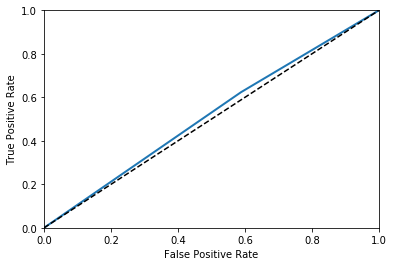

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fpr, tpr, thresholds = roc_curve(preds_sgd, y_test)
plot_roc_curve(fpr, tpr)

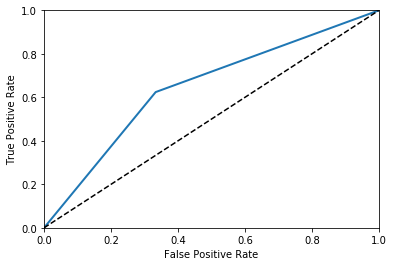

In [44]:
fpr, tpr, thresholds = roc_curve(preds_rfc, y_test)
plot_roc_curve(fpr, tpr)

## SVC

In [21]:
svc = SVC()
param_grid = [
    {'C': np.logspace(-2, 2, 4),
     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'degree': [3, 4],
     'tol': [0.001],
     'gamma': np.logspace(-2, 2, 4),
    }]
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
print(best_svc)

SVC(C=0.21544346900318834, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [22]:
print('svc', cross_val_score(best_svc, X_train, y_train, cv=5, scoring='f1'))

sgd [0.79775281 0.80337079 0.77653631 0.78089888 0.79120879]


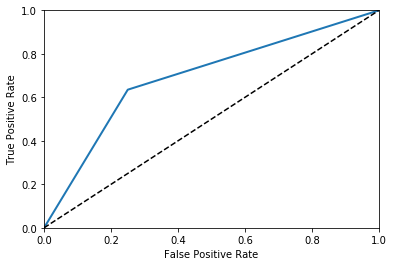

In [23]:
preds_svc = best_svc.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_svc, y_test)
plot_roc_curve(fpr, tpr)

In [46]:
f1_score(preds, y_test)

0.7672634271099744

## Ridge Classifier

In [73]:
rc = RidgeClassifier()
param_grid = [
    {'alpha': np.logspace(-2, 2, 4),
     'max_iter': np.logspace(2, 8, 3),
     'tol': [0.001],
     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }]
grid_search = GridSearchCV(rc, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_rc = grid_search.best_estimator_
print(best_rc)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Fra

RidgeClassifier(alpha=100.0, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=100.0, normalize=False,
        random_state=None, solver='auto', tol=0.001)


In [74]:
print('rc', cross_val_score(best_rc, X_train, y_train, cv=5, scoring='f1'))

rc [0.78378378 0.78378378 0.7826087  0.7826087  0.7826087 ]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


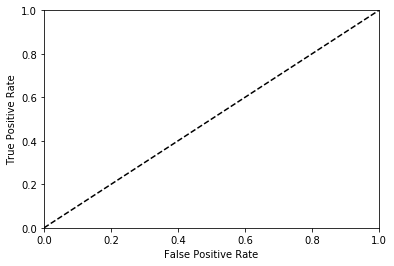

In [77]:
preds_rc = best_rc.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_rc, y_test)
plot_roc_curve(fpr, tpr)

## Plot the result of SVC

(-50000.0, 1000000)

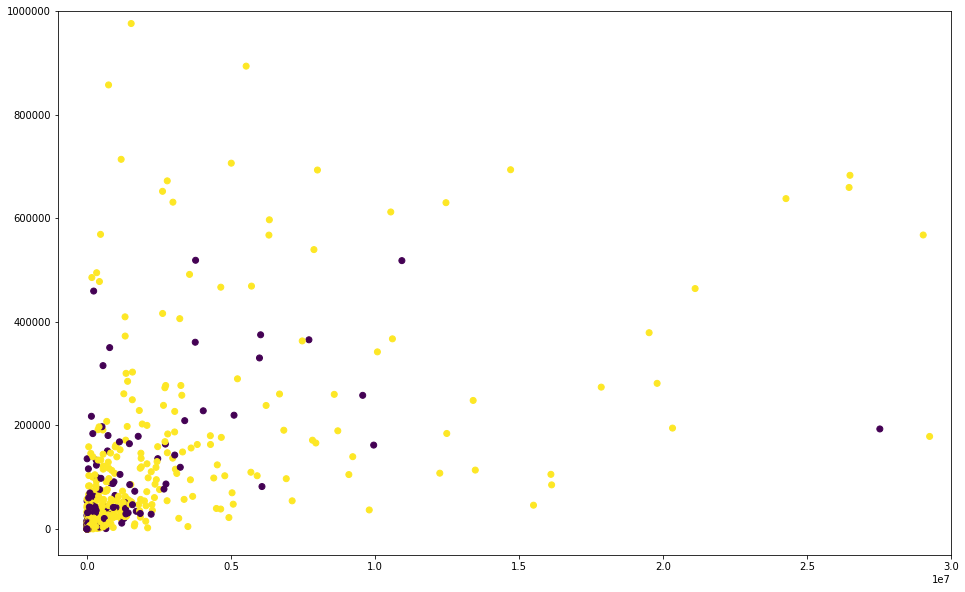

In [120]:
likes = df.likes
talking = df.talking_about_count
colors = df.stock_symbol
fig = plt.figure(figsize=(16, 10))
plt.scatter(likes, talking, c=colors)
plt.xlim([-1e6, 0.3e8])
plt.ylim([-0.5e5, 1000000])

## KNN

In [105]:

param_grid = [
    {'n_neighbors': [1, 5, 10],
     'leaf_size': [15, 30, 60]
    }]
grid_search = GridSearchCV(KNN(), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


In [106]:
print('knn', cross_val_score(best_knn, X_train, y_train, cv=5, scoring='f1'))

knn [0.75       0.75399361 0.6875     0.64335664 0.71895425]


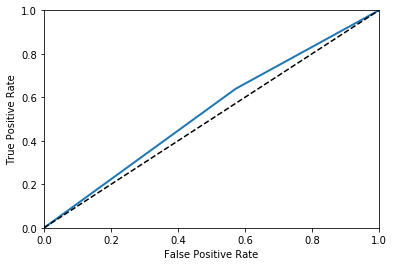

In [107]:
preds_knn = best_knn.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_knn, y_test)
plot_roc_curve(fpr, tpr)